---
title: Local Autocorrelation
author: "Serge Rey"
date: "2023-04-11"
jupyter: python3
format:
  html:
    theme:
      light: flatly
      dark: darkly
    toc: true
---

In [1]:
import warnings

warnings.filterwarnings("ignore")

# Local Spatial Autocorrelation

In the previous chapter, we explored how global measures of spatial autocorrelation can help us determine whether the overall spatial distribution of our phenomenon of interest is compatible with a geographically random process. These statistics are useful: the presence of spatial autocorrelation has important implications for subsequent statistical analysis. From a substantive perspective, spatial autocorrelation could reflect the operation of processes that generate association between the values in nearby locations. This could represent *spillovers*, where outcomes at one site influence other sites; or could indicate *contagion*, where outcomes at one site *causally influence* other sites. As we will see later in Chapter 11, it could simply be the result of systematic spatial variation (or, as we will call it then, _heterogeneity_). Spatial autocorrelation also sometimes arises from data measurement and processing. In this case, the dependence is a form of non-random noise rather than due to substantive processes. For example, when "down-sampling" geographic data, sometimes large patches of identical values can be created. These may only be artifacts of the interpolation, rather than substantive autocorrelation. Regardless of whether the spatial autocorrelation is due to substantive or nuisance sources, it is a form of non-randomness that complicates statistical analysis. For these reasons, the ability to determine whether spatial autocorrelation is present in a geographically referenced data set is a critical component of the geographic data science toolbox. 

Despite their importance, global measures of spatial autocorrelation are "whole map" statistics. They provide a single summary for an entire data set. For example,
Moran's $I$ is a good tool to summarize a dataset into a single value that captures the degree of geographical clustering (or dispersion, if negative). However, Moran's $I$ does not indicate areas within the map where specific types of values (e.g. high, low) are clustered, or instances of explicit dispersion. 
In other words, Moran's I can tell us whether values in our map *cluster* together (or disperse) overall, but it will not inform us about where specific *clusters* (or outliers) are.

In this chapter, we introduce local measures of spatial autocorrelation.
Local measures of spatial autocorrelation focus on the relationships between _each_ observation and its surroundings, rather than providing a single summary of these relationships across the map. In this sense, they are not summary statistics but scores that allow us to learn more about the spatial structure in our data. The general intuition behind the metrics however is similar to that of global ones. Some of them are even mathematically connected, where the global version can be decomposed into a collection of local ones. One such example are Local Indicators of Spatial Association (LISAs) {cite}`Anselin1995local`, which we use to build the understanding of local spatial autocorrelation, and on which we spend a good part of the chapter. Once such concepts are firmed, we introduce a couple alternative statistics that present complementary information or allow us to obtain similar insights for categorical data. Although very often these statistics are used with data expressed in geo-tables, there is nothing fundamentally connecting the two. In fact, the application of these methods to large surfaces is a promising area of work. For that reason, we close the chapter with an illustration of how one can run these statistics on data stored as surfaces.

## An empirical illustration: the EU Referendum

We continue with the same dataset about Brexit voting that we examined in the previous chapter, and thus we utilize the same imports and initial data preparation steps:

In [2]:
import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn  # Graphics
import geopandas  # Spatial data manipulation
import pandas  # Tabular data manipulation
import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import contextily  # Background tiles

We read the vote data as a non-spatial table:

In [3]:
ref = pandas.read_csv(
    "./brexit/brexit_vote.csv", index_col="Area_Code"
)

And the spatial geometries for the local authority districts in Great Britain:

lads = geopandas.read_file(
    "./brexit/local_authority_districts.geojson"
).set_index("lad16cd")

Then, we "trim" the `DataFrame` so it retains only what we know we will need, reproject it to spherical mercator, and drop rows with missing data:

In [5]:
db = (
    geopandas.GeoDataFrame(
        lads.join(ref[["Pct_Leave"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[
        ["objectid", "lad16nm", "Pct_Leave", "geometry"]
    ]
    .dropna()
)

db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int64   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int64(1), object(1)
memory usage: 14.8+ KB


Although there are several variables that could be considered, we will focus on `Pct_Leave`, which measures the proportion of votes in the UK Local Authority that wanted to Leave the European Union. With these elements, we can generate a choropleth to get a quick sense of the spatial distribution of the data we will be analyzing. Note how we use some visual tweaks (e.g., transparency through the `alpha` attribute) to make the final plot easier to read.

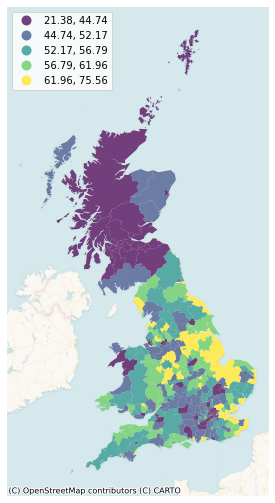

In [6]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off();

As in the previous chapter, we require a spatial weights matrix to implement our statistic. Here, we will use eight nearest neighbors for the sake of the example, but the discussion in the earlier chapter on weights applies in this context, and other criteria would be valid too. We also row-standardize them:


In [7]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

## Motivating Local Spatial Autocorrelation

To better understand the underpinnings of local spatial autocorrelation, we return to the Moran Plot as a graphical tool. In this context, it is more intuitive to represent the data in a standardised form, as it will allow us to more easily discern a typology of spatial structure. Let us first calculate the spatial lag of our variable of interest:

In [8]:
db["w_Pct_Leave"] = weights.spatial_lag.lag_spatial(
    w, db["Pct_Leave"]
)

And their respective standardized versions, where we subtract the average and divide by the standard deviation:

In [9]:
db["Pct_Leave_std"] = db["Pct_Leave"] - db["Pct_Leave"].mean()
db["w_Pct_Leave_std"] = db["w_Pct_Leave"] - db["Pct_Leave"].mean()

Technically speaking, creating a Moran Plot is very similar to creating any other scatter plot:

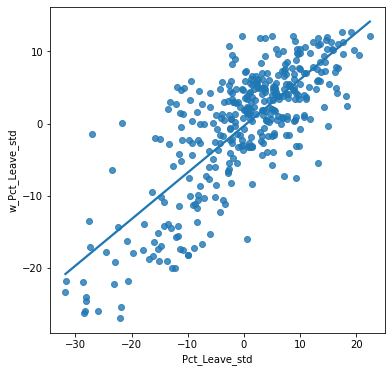

In [10]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="Pct_Leave_std", y="w_Pct_Leave_std", data=db, ci=None
);

Using standardized values, we can immediately divide each variable (the percentage that voted to leave, and its spatial lag) in two groups: those with above-average leave voting, which have positive standardized values; and those with below-average leave voting, which feature negative standardized values. Applying this thinking to both the percentage to leave and its spatial lag, divides a Moran Plot in four quadrants. Each of them captures a situation based on whether a given area displays a value above the mean (high) or below (low) in either the original variable (`Pct_Leave`) or its spatial lag (`w_Pct_Leave_std`). Using this terminology, we name the four quadrants as follows: high-high (HH) for the top-right, low-high (LH) for the top-left, low-low (LL) for the bottom-left, and high-low (HL) for the bottom right. Graphically, we can capture this as follows:

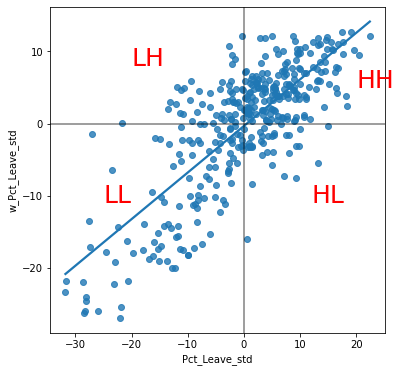

In [11]:
# Setup the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="Pct_Leave_std", y="w_Pct_Leave_std", data=db, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(20, 5, "HH", fontsize=25, c="r")
plt.text(12, -11, "HL", fontsize=25, c="r")
plt.text(-20, 8.0, "LH", fontsize=25, c="r")
plt.text(-25, -11.0, "LL", fontsize=25, c="r")
# Display
plt.show()

## Local Moran's $I_i$

One way to look at the figure above is as a classification of each observation in the dataset depending on its value and that of its neighbors. Furthermore, this classification is exhaustive: every point is assigned a label. But remember local measures help us to identify areas of _unusual_ concentration of values. Clusters will represent values of one type that are _unlikely_ to appear under the assumption of spatial randomness. To know whether each location belongs to a *statistically significant* cluster of a given kind, we thus need to compare it with what we would expect if the data were allocated over space in a completely random way. However, what we are interested in is whether the strength with which the values are concentrated is unusually high. This is exactly what LISAs are designed to do. A detailed description the statistical underpinnings of LISAs is beyond the scope of this chapter. If you would like to delve deeper into the math and probability challenges arising, a good recent reference is {cite}`sauer2021ga`. In this context, we will provide some intuition about how they work in one LISA statistic, the Local Moran's $I_i$. 

The core idea of a local Moran's $I_i$ is to identify cases in which the value of an observation and the average of its surroundings is either more similar (HH or LL in the scatterplot above) or dissimilar (HL, LH) than we would expect from pure chance. The mechanism to do this is similar to the one in the global Moran's I, but applied in this case to each observation. This results in as many statistics as original observations. The formal representation of the statistic can be written as:

$$
I_i = \dfrac{z_i}{m_2} \displaystyle\sum_j w_{ij} z_j \; ; \; m_2 = \dfrac{\sum_i z_i^2}{n}
$$

where $m_2$ is the second moment (variance) of the distribution of values in the data, $z_i = y_i - \bar{y}$, $w_{i,j}$ is the spatial weight for the pair of observations $i$ and $j$, and $n$ is the number of observations.

LISAs are widely used in many fields to identify geographical clusters of values or find geographical outliers. They are a useful tool that can quickly return areas in which values are concentrated and provide suggestive evidence about the processes that might be at work. For these reasons, they have a prime place in the geographic data science toolbox. Among many other applications, LISAs have been used to identify geographical clusters of poverty {cite}`Dawson2018`, map ethnic enclaves {cite}`Johnston2010EPA`, delineate areas of particularly high/low economic activity {cite}`Torres2014`, or identify clusters of contagious disease {cite}`zhang2020`. The Local Moran's $I_i$ statistic is only one of a wide variety of LISAs that can be used on many different types of spatial data.

In Python, we can calculate LISAs in a very streamlined way thanks to `esda`. To compute local Moran statistics, we use the `Moran_Local` function:

In [12]:
lisa = esda.moran.Moran_Local(db["Pct_Leave"], w)

We need to pass the variable of interest—proportion of Leave votes in this context—and the spatial weights that describes the neighborhood relations between the different areas that make up the dataset. This creates a LISA object (`lisa`) that has a number of attributes of interest. The local indicators themselves are in the `Is` attribute and we can get a sense of their distribution using `seaborn`:

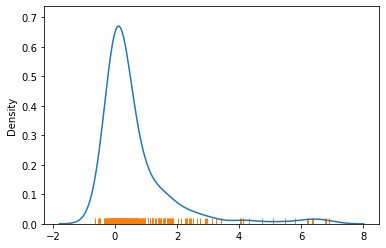

In [13]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

The figure reveals a rather skewed distribution of local Moran's $I_i$ statistics. This outcome is due to the dominance of positive forms of spatial association, implying most of the local statistic values will be positive. Here it is important to keep in mind that the high positive values arise from value similarity in space, and this can be due to either high values being next to high values *or* low values next to low values. The local $I_i$ values alone cannot distinguish these two cases.

The values in the left tail of the density represent locations displaying negative spatial association. There are also two forms, a high value surrounded by low values, or a low value surrounded by high valued neighboring observations. And, again, the  $I_i$ statistic cannot distinguish between the two cases.

Because of their very nature, looking at the numerical result of LISAs is not always the most useful way to exploit all the information they can provide. Remember we are calculating a statistic for every single observation in the data so, if we have many of them, it will be difficult to extract any meaningful pattern. In this context, a choropleth can help. At first glance, this may seem to suggest that a choropleth of the $I_i$  values would be a useful way to visualize the spatial distribution. We can see such map in the top-left panel of the figure below and, while it tells us whether the local association is positive (HH/LL) or negative (HL/LH), it cannot tell, for example, whether the yellow areas in Scotland are similar to those in the eastern cluster of yellow areas. Are the two experiencing similar patterns of spatial association, or is one of them HH and the other LL? Also, we know that values around zero will not be statistically significant. Which local statistics are thus significant and which ones non-significant from a statistical point of view? In other words, which ones can be considered statistical clusters and which ones mere noise?

To answer these questions, we need to bring in additional information that we have computed when calculating the LISA statistics. We do this in four acts. The first one we have already mentioned: a straighforward choropleth of the local statistic of each area. The other three include information on the quadrant each area is assigned into, whether the statistic is considered significant or not, and a combination of those two in a single so-called _cluster_ map. A handy tool in this context is the `splot` library, part of the Pysal family, which provides a lightweight visualisation layer for spatial statistics:

In [14]:
from splot import esda as esdaplot

With all pieces in place, let's first get busy building the figure:

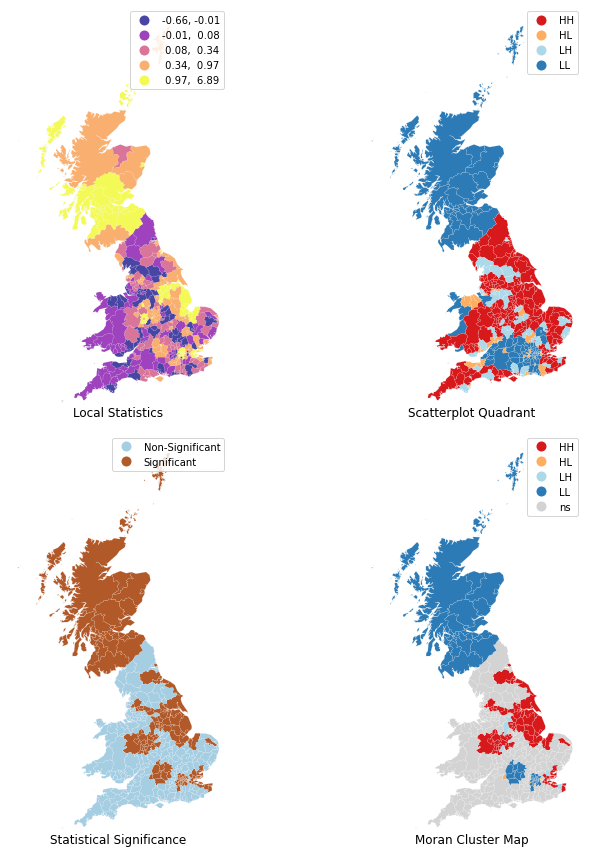

In [15]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quandrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pandas.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quandrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimise in-betwee white space
f.tight_layout()

# Display the figure
plt.show()

The purple and yellow locations in the top-right map display the largest magnitude (positive and negative values) for the local statistics $I_i$. Yet, remember this signifies positive spatial autocorrelation, which can be of high _or_ low values. This map thus cannot distinguish between areas with low support for the Brexit vote and those highly in favour.

To distinguish between these two cases, the map in the upper-right shows the location of the LISA statistic in the quadrant of the Moran Scatter plot. This indicates whether the positive (or negative) local association exists within a specific *quadrant*, such as the High-High quadrant. This information is recorded in the `q` attribute of the `lisa` object:

In [16]:
lisa.q[:10]

array([1, 1, 1, 1, 1, 1, 4, 1, 4, 1])

The correspondence between the numbers in the `q` attribute and the actual quadrants is as follows: `1` represents observations in the HH quadrant, `2` those in the LH one, `3` in the LL region, and `4` in the HL quadrant. Comparing the two maps in the top row reveals that the positive local association in Scotland is due to low support for Brexit, while the positive local association in the south is among local authorities that strongly support Brexit. Overall, we can obtain counts of areas in each quadrant as follows:

In [17]:
counts = pandas.value_counts(lisa.q)
counts

1    183
3    113
2     50
4     34
dtype: int64

Showing that the high-high (1), and low-low (3), values are predominant. Care must be taken, however, in the interpretation of these first two maps, as the underlying statistical significance of the local values has not been considered. We have simply mapped the raw LISA value alongside the quadrant in which the local statistic resides. To statistical significance, the bottom left map distinguishes those polygons whose pseudo p-value is above (_"Non-Significant"_) or below (_"Significant"_) the threshold value of 5% we use in this context. An examination of the map suggests that quite a few local authorities have local statistics that are small enough so as to be compatible with pure chance. 

Therefore, in order to focus on the areas that are most promising, we need to include significance information alongside the quadrant and local statistic. Together, this "cluster map" (as it is usually called) extracts significant observations -those that are highly unlikely to have come from pure chance- and plots them with a specific color depending on their quadrant category. All of the needed pieces are contained inside the `lisa` object we have created above and, if passed in tandem with the geo-table containing the geographies it relates to, `splot` will make a cluster map for us.

Reading the clustermap reveals a few interesting aspects that would have been hard to grasp by looking at the other maps only and that are arguably more relevant for an analysis of the data. First, fewer than half of polygons that have degrees of local spatial association strong enough to reject the idea of pure chance:

In [18]:
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)

41.578947368421055

A little over 41% of the local authorities are considered, by this analysis, to be part of a spatial cluster. Second, we identify three clear areas of low support for leaving the EU: Scotland, London, and the area around Oxford (North-West of London). And third, although there appeared to be many areas with concentrated values indicating high support, it is only the region in the North-East and West of England whose spatial concentration shows enough strength to reasonably rule out pure chance.

Before we move on from the LISA statistics, let's dive into a bit of the data engineering required to "export" significance levels and other information, as well as dig a bit further into what these numbers represent. The latter is useful if we need to work with them as part of a broader data pipeline. So far, cluster maps have been handled by `splot`, but there is quite a bit that happens under the hood. If we needed to recreate one of its maps, or to use this information in a different context, we would need to extract them out of our `lisa` object, and link them up to the original `db` table. Here is one way you can do this.

First, we pull the information computed in `lisa` and insert it in the main data table:

In [19]:
# Assign pseudo P-values to `db`
db["p-sim"] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
db["sig"] = sig
# Print top of the table to inspect
db[["sig", "p-sim"]].head()

,sig,p-sim
lad16cd,,
E06000001,1,0.008
E06000002,1,0.008
E06000003,1,0.011
E06000004,1,0.011
E06000010,1,0.012


In [20]:
# Print bottom of the table to inspect
db[["sig", "p-sim"]].tail()

,sig,p-sim
lad16cd,,
W06000018,0,0.498
W06000019,0,0.487
W06000021,0,0.475
W06000022,0,0.353
W06000023,0,0.278


Thus, the first five values are statistically significant, while the last five observations are not.

Let us stop for a second on these two steps. First, we consider the `sig` column. Akin to global Moran's I, `esda` automatically computes a pseudo p-value for each LISA. Because some instances of the LISA statistics may not be statistically significant, we want to identify those with a p-value small enough that rules out the possibility of obtaining a similar value in random maps. A few different ways of generating random maps are considered by `esda`, but we focus on a strategy that actually simulates hundreds of thousands of random maps to get a rough idea of the possible local statistic values at each local authority given the data we saw. In addition, we follow a similar reasoning as with global Moran's I and use 5% as the threshold for statistical significance. To identify these values, we create a variable, `sig`, that contains `True` if the p-value of the observation satisfies the condition, and `False` otherwise.

Next, we construct our quadrant values using the `q` attribute which records the Moran Scatterplot quadrant for each local value. However, we now mask these values using the newly created binary significance measure `sig`, so only observations in a quadrant that are considered significant are labeled as part of that given quadrant. The remainder are labelled as non-significant.

In [21]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
db["labels"] = pandas.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=db.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
db["labels"].head()

lad16cd
E06000001    HH
E06000002    HH
E06000003    HH
E06000004    HH
E06000010    HH
Name: labels, dtype: object

These cluster labels are meaningful if you know of the Moran Plot. To help making them a bit more intuitive, a terminology that is sometimes used goes as follows. Positive forms of local spatial autocorrelation are of two types. First, HH observations, which we can term "hot spots", represent areas where values at the site and its surroundings are larger than average. Second, LL observations, significant clusters of low values surrounded by low values, are sometimes referred to as "cold spots". Negative forms of local spatial autocorrelation also include two cases. When the focal observation displays low values but its surroundings have high values (LH), we call them "doughnuts". Conversely, areas with high values but neighboured by others with low values (HL) can be referred to as "diamonds in the rough". We note this terminology is purely mnemonic, but recognise in some cases it can help remembering the interpretation of local statistics. 

After building these new columns, analysis on the overall trends of LISA statistics is more straightforward than from the `lisa` object. For example, an overview of the distribution of labels is one line away:

In [22]:
db["labels"].value_counts()

Non-Significant    222
HH                  75
LL                  73
LH                   6
HL                   4
Name: labels, dtype: int64

This shows, for one, that most local statistics are *not* statistically significant. Among those that are, we see many more hotspots/coldspots than doughnuts/diamonds-in-the-rough. This is consistent with the skew we saw in the distribution of local statistics earlier. 

## Getis and Ord's local statistics

Similar to the global case, there are more local indicators of spatial correlation than the local Moran's I. `esda` includes Getis and Ord's $G_i$-type statistics. These are a different kind of local statistic which are commonly used in two forms: the $G_i$ statistic, which omits the value at a site in its local summary, and the $G_i^*$, which includes the site's own value in the local summary. The way to calculate them also follows similar patterns as with the Local Moran's $I_i$ statistics above. Let us see how that would look like for our Brexit example:

In [23]:
# Gi
go_i = esda.getisord.G_Local(db["Pct_Leave"], w)
# Gi*
go_i_star = esda.getisord.G_Local(db["Pct_Leave"], w, star=True)

As the local statistics they are, it is best to explore them by plotting them on a map. Unlike with LISA though, the $G$ statistics only allow to identify positive spatial autocorrelation. When standardized, positive values imply clustering of high values, while negative implies grouping of low values. Unfortunately, it is not possible to discern spatial outliers.

Unlike with LISAs, `splot` does not support vislualisation of G statistics at this point. To visualise their output, we will instead write a little function that generates the map from the statistic's output object and its set of associated geometries:

In [24]:
def g_map(g, db, ax):
    """
    Create a cluster map
    ...

    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    db     : GeoDataFrame
             Table aligned with values in `g` and containing
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    """
    ec = "0.8"

    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = db.loc[sig == False, "geometry"]
    ns.plot(ax=ax, color="lightgrey", edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = db.loc[(g.Zs > 0) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="red", edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = db.loc[(g.Zs < 0) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1)
    # Style and draw
    contextily.add_basemap(
        ax,
        crs=db.crs,
        source=contextily.providers.Stamen.TerrainBackground,
    )
    # Flag to add a star to the title if it's G_i*
    st = ""
    if g.star:
        st = "*"
    # Add title
    ax.set_title(f"G{st} statistic for Pct of Leave votes", size=15)
    # Remove axis for aesthetics
    ax.set_axis_off()
    return ax

With this function at hand, generating $G_i^{(*)}$ cluster maps is as straightforward as it is for LISA outputs through `splot`:

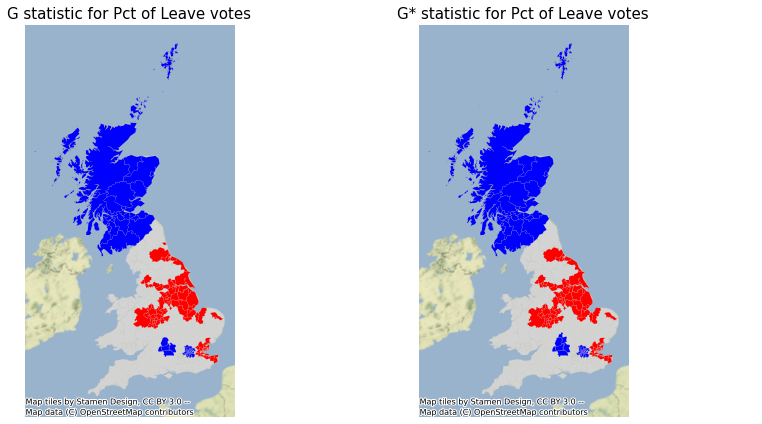

In [25]:
# Setup figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics
for g, ax in zip([go_i, go_i_star], axs.flatten()):
    # Generate the statistic's map
    ax = g_map(g, db, ax)
# Tight layout to minimise blank spaces
f.tight_layout()
# Render
plt.show()

In this case, the results are virtually the same for $G_i$ and $G_i^*$. Also, at first glance, these maps appear to be visually similar to the final LISA map from above. Naturally, this leads to the question: *why use the $G$ statistics at all?* The answer to this question is that the two sets of local statistics, local $I$ and the local $G$, are complementary statistics. The local $I$ statistic (on its own) gives an indication of cluster/outlier status, and the local $G$ shows which side of the hotspot/coldspot divide the observation is on. Alternatively, the local Moran's $I_i$ cluster map provides both pieces of information, but can be more challenging to visualize all at once. Thus, it depends on your analytical preferences and the point of the analysis at hand. 



## Conclusion

Local statistics are one of the most commonly-used tools in the geographic data science toolkit. When used properly, local statistics provide a powerful way to analyze and visualize the structure of geographic data. The Local Moran's $I_i$ statistic, as Local Indicator of Spatial Association, summarizes the co-variation between observations and their immediate surroundings. The Getis-Ord local $G$ statistics, on the other hand, compare the sum of values in the area around each site. Regardless, learning to use local statistics effectively is important for any geographic data scientist, as they are the most common "first brush" geographic statistic for many analyses. 

## Questions

1. Do the same Local Moran analysis done for `Pct_Leave`, but using `Pct_Turnout`. Is there a geography to how involved people were in different places? Where was turnout percentage (relatively) higher or lower? 
2. Do the same Getis-Ord analysis done for `Pct_Leave`, but using `Pct_Turnout`. 
3. Local Moran statistics are premised on a few distributional assumptions. One well-recognized concern with Moran statistics is when they are estimated for *rates*. Rate data is distinct from other kinds of data because it embeds the relationship between two quantities: the event and the population. For instance, in the case of Leave voting, the "event" is a person voting leave, and the "population" could be the number of eligible voters, the number of votes cast, or the total number of people. This usually only poses a problem for analysis when the event outcome is somehow dependent on the population. 
    - Using our past analytical steps, build a new `db` dataframe from `ref` and `lads` that contains the `Electorate`, `Votes_Cast`, and `Leave` columns. 
    - From this new dataframe, make scatterplots of:
       - the number of votes cast and the percent leave vote
       - the size of the electorate and the percent of leave vote
    - Based on your answers to the previous point, does it appear that there is a relationship between the event and the population size? Use `scipy.stats.kendalltau` or `scipy.stats.pearsonr`  to confirm your visual intuition. 
    - Using `esda.moran.Moran_Rate`, estimate a global Moran's I that takes into account the rate structure of `Pct_Leave`, using the `Electorate` as the population. Is this estimate different from the one obtained without taking into account the rate structure? What about when `Votes_Cast` is used for the population? 
    - Using `esda.moran.Moran_Local_Rate`, estimate *local* Moran's I treating Leave data as a rate.
        - does any site's local I change? Make a scatterplot of the `lisa.Is` you estimated before and this new rate-based local Moran. 
        - does any site's local I change their outlier/statistical significance classifications? Use `pandas.crosstab` to examine how many classifications change between the two kinds of statistic. Make sure to consider observations' statistical significances in addition to their quadrant classification.
    - Make two maps, side by side, of the local statistics without rate correction and with rate correction. Does your interpretation of the maps change depending on the correction?
4. Local statistics use *permutation-based* inference for their significance testing. This means that, to test the statistical significance of a local relationship, values of the observed variable are *shuffled* around the map. These large numbers of *random* maps are then used to compare against the observed map. Local inference requires some restrictions on how each shuffle occurs, since each observation must be "fixed" and compared to randomly-shuffle neighboring observations. The distribution of local statistics for each "shuffle" is contained in the `.rlisas` attribute of a Local Moran object. 
    - For the first observation, make a `seaborn.distplot` of its shuffled local statistics. Add a vertical line to the histogram using `plt.axvline()`. 
    - Do the same for the last observation as well. 
    - Looking only at their permutation distributions, do you expect the first LISA statistic to be statistically-significant? Do you expect the last?
5. LISAs have some amount of fundamental uncertainty due to their estimation. This is called the `standard error` of the statistic.
    - The standard errors are contained in the `.seI_sim` attribute. Make a map of the standard errors. Are there any areas of the map that appear to be more uncertain about their local statistics? 
    - compute the standard deviation of each observation's "shuffle" distribution, contained in the `.rlisas` attribute. Verify that the standard deviation of this shuffle distribution is the same as the standard errors in `seI_sim`. 
6. Local Getis-Ord statistics come in two forms. As discussed above, Getis-Ord $G_i$ statistics *omit* each site from their own local statistic. In contrast, $G_i^*$ statistics *include* the site in its own local statistic.
    - Make a scatterplot of the two types of statistic, contained in `gostats.Zs` and `gostars.Zs` to examine how similar the two forms of the Getis-Ord statistic are. 
    - The two forms of the Getis-Ord statistic differ by their inclusion of the *site* value, $y_i$, in the value for the $G_i$ statistic at that site. So, make a scatterplot of the percent leave variable and the *difference* of the two statistics. Is there a relationship between the percent leave vote and the difference in the two forms of the Getis-Ord statistic? Confirm this for yourself using `scipy.stats.kendalltau` or `scipy.stats.pearsonr`. 

## Next Steps
 
For more thinking on the foundational methods and concepts in local testing, Fotheringham is a classic:
 
Fotheringham, A. Stewart. 1997. "Trends in Quantitative Methods I: Stressing the local." *Progress in Human Geography* 21(1): 88-96. 
 
More recent discussion on local statistics (in the context of spatial statistics more generally) is provided by Nelson:

Nelson, Trisalyn. "Trends in Spatial Statistics." *The Professional Geographer* 64(1): 83-94. 